# The art of using t-SNE for single-cell transcriptomics

## Tasic et al. dataset

In [1]:
# Prepare

%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns
import pandas as pd
import matplotlib
import pickle
import scipy
import time
from scipy import sparse

from sklearn.metrics import pairwise_distances

# import tsne
import sys; sys.path.append('/Users/dsmolyak/Downloads/FIt-SNE-master')
from fast_tsne import fast_tsne

# import my feature selection function and other helpful stuff
import rnaseqTools

def sns_styleset():
    sns.set_context('paper')
    sns.set_style('ticks')
    matplotlib.rcParams['axes.linewidth']    = .75
    matplotlib.rcParams['xtick.major.width'] = .75
    matplotlib.rcParams['ytick.major.width'] = .75
    matplotlib.rcParams['xtick.major.size'] = 3
    matplotlib.rcParams['ytick.major.size'] = 3
    matplotlib.rcParams['xtick.minor.size'] = 2
    matplotlib.rcParams['ytick.minor.size'] = 2
    matplotlib.rcParams['font.size']       = 7
    matplotlib.rcParams['axes.titlesize']  = 7
    matplotlib.rcParams['axes.labelsize']  = 7
    matplotlib.rcParams['legend.fontsize'] = 7
    matplotlib.rcParams['xtick.labelsize'] = 7
    matplotlib.rcParams['ytick.labelsize'] = 7

sns_styleset()

Download the data from here: http://celltypes.brain-map.org/rnaseq and unpack. Direct links:
 * VISp: http://celltypes.brain-map.org/api/v2/well_known_file_download/694413985
 * ALM: http://celltypes.brain-map.org/api/v2/well_known_file_download/694413179

To get the information about cluster colors and labels (`sample_heatmap_plot_data.csv`), open the interactive data browser http://celltypes.brain-map.org/rnaseq/mouse/v1-alm, go to "Sample Heatmaps", click "Build Plot!" and then "Download data as CSV". For later reproducibility, this file is also provided in this github repository (`data` folder).

In [2]:
%%time

# filename = './data/tasic-nature/mouse_VISp_2018-06-14_exon-matrix.csv'
filename = './data/mouse_VISp_gene_expression_matrices_2018-06-14/mouse_VISp_2018-06-14_exon-matrix.csv'
counts1, genes1, cells1 = rnaseqTools.sparseload(filename)

# filename = './data/tasic-nature/mouse_ALM_2018-06-14_exon-matrix.csv'
filename = './data/mouse_ALM_gene_expression_matrices_2018-06-14/mouse_ALM_2018-06-14_exon-matrix.csv'
counts2, genes2, cells2 = rnaseqTools.sparseload(filename)

counts = sparse.vstack((counts1, counts2), format='csc')

cells = np.concatenate((cells1, cells2))

if np.all(genes1==genes2):
    genes = np.copy(genes1)

.............................................. done
.............................................. done
CPU times: user 5min 53s, sys: 43.5 s, total: 6min 37s
Wall time: 6min 44s


In [3]:
genesDF = pd.read_csv('./data/mouse_VISp_gene_expression_matrices_2018-06-14/mouse_VISp_2018-06-14_genes-rows.csv')
ids     = genesDF['gene_entrez_id'].tolist()
symbols = genesDF['gene_symbol'].tolist()
id2symbol = dict(zip(ids, symbols))
genes = np.array([id2symbol[g] for g in genes])

clusterInfo = pd.read_csv('data/tasic-sample_heatmap_plot_data.csv')
goodCells  = clusterInfo['sample_name'].values
ids        = clusterInfo['cluster_id'].values
labels     = clusterInfo['cluster_label'].values
colors     = clusterInfo['cluster_color'].values

clusterNames  = np.array([labels[ids==i+1][0] for i in range(np.max(ids))])
clusterColors = np.array([colors[ids==i+1][0] for i in range(np.max(ids))])
clusters   = np.copy(ids)

ind = np.array([np.where(cells==c)[0][0] for c in goodCells])
counts = counts[ind, :]

areas = (ind < cells1.size).astype(int)

clusters = clusters - 1

tasic2018 = {'counts': counts, 'genes': genes, 'clusters': clusters, 'areas': areas, 
             'clusterColors': clusterColors, 'clusterNames': clusterNames}

print(tasic2018['counts'].shape)
print(np.sum(tasic2018['areas']==0))
print(np.sum(tasic2018['areas']==1))
print(np.unique(tasic2018['clusters']).size)

# pickle.dump(tasic2018, open('../data/tasic-nature/tasic2018.pickle', 'wb'))

(23822, 45768)
9573
14249
133


In [4]:
total_count = 0
for cluster in np.unique(tasic2018['clusters']):
    curr_count = np.count_nonzero(tasic2018['clusters'] == cluster)
    print(cluster, curr_count)
    total_count += curr_count**2
total_count

0 68
1 76
2 115
3 287
4 534
5 879
6 76
7 68
8 71
9 48
10 86
11 49
12 56
13 148
14 213
15 80
16 289
17 128
18 118
19 137
20 366
21 115
22 211
23 116
24 289
25 242
26 232
27 207
28 61
29 179
30 67
31 178
32 59
33 74
34 238
35 63
36 89
37 115
38 555
39 203
40 79
41 208
42 61
43 126
44 103
45 131
46 80
47 71
48 165
49 36
50 129
51 69
52 72
53 112
54 65
55 200
56 810
57 63
58 624
59 89
60 108
61 212
62 673
63 125
64 70
65 119
66 1404
67 215
68 70
69 435
70 49
71 123
72 54
73 412
74 387
75 184
76 704
77 224
78 72
79 122
80 230
81 216
82 174
83 1049
84 200
85 380
86 172
87 75
88 91
89 22
90 102
91 109
92 220
93 203
94 43
95 122
96 183
97 300
98 180
99 241
100 259
101 98
102 82
103 65
104 278
105 318
106 210
107 107
108 118
109 60
110 46
111 51
112 59
113 46
114 16
115 56
116 18
117 583
118 52
119 4
120 13
121 83
122 37
123 12
124 80
125 7
126 40
127 36
128 110
129 183
130 7
131 30
132 106


9902208

In [55]:
%%time
nonzeros = np.sum(tasic2018['counts'] != 0)

CPU times: user 1.99 s, sys: 4.89 s, total: 6.87 s
Wall time: 8.99 s


In [56]:
nonzeros / (tasic2018['counts'].shape[0] * tasic2018['counts'].shape[1])

0.1983409175500795

In [39]:
tasic2018['counts'].shape

(23822, 45768)

# Distance Experiments

In [83]:
%%time
metrics = [0,0.2,0.4,1,2]
inside_dists, outside_dists = {metric: {} for metric in metrics}, {metric: {} for metric in metrics}
for cluster in np.unique(tasic2018['clusters']):
    print(cluster)
    cluster_size = np.count_nonzero(tasic2018['clusters'] == cluster)
    curr_cluster = tasic2018['counts'][tasic2018['clusters'] == cluster]
    random_points = np.random.choice(cluster_size, min(11, cluster_size), replace=False)
    curr_point = curr_cluster[random_points[0]].toarray().flatten()
    in_compare = np.array([curr_cluster[rand].toarray().flatten() for rand in random_points[1:]])
    
    random_points = np.random.choice(tasic2018['counts'].shape[0], 10, replace=False)
    cluster_index = np.nonzero(tasic2018['clusters'] == cluster)[0]
    random_points = [rand for rand in random_points if rand not in cluster_index]
    out_compare = tasic2018['counts'][random_points].toarray()
    for dist_metric in metrics:
        inside_dists[dist_metric][cluster] = [np.linalg.norm(curr_point-other, dist_metric) for other in in_compare]
        outside_dists[dist_metric][cluster] = [np.linalg.norm(curr_point-other, dist_metric) for other in out_compare]

0

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

51

52

53

54

55

56

57

58

59

60

61

62

63

64

65

66

67

68

69

70

71

72

73

74

75

76

77

78

79

80

81

82

83

84

85

86

87

88

89

90

91

92

93

94

95

96

97

98

99

100

101

102

103

104

105

106

107

108

109

110

111

112

113

114

115

116

117

118

119

120

121

122

123

124

125

126

127

128

129

130

131

132

CPU times: user 2min 16s, sys: 9.41 s, total: 2min 26s
Wall time: 1min 39s


In [90]:
pca_50_counts = X
metrics = [0.2,0.4,1,2]
inside_dists_pca, outside_dists_pca = {metric: {} for metric in metrics}, {metric: {} for metric in metrics}
for cluster in np.unique(tasic2018['clusters']):
#     print(cluster)
    cluster_size = np.count_nonzero(tasic2018['clusters'] == cluster)
    curr_cluster = pca_50_counts[tasic2018['clusters'] == cluster]
    random_points = np.random.choice(cluster_size, min(11, cluster_size), replace=False)
    curr_point = curr_cluster[random_points[0]]
    in_compare = np.array([curr_cluster[rand] for rand in random_points[1:]])
    
    random_points = np.random.choice(pca_50_counts.shape[0], 10, replace=False)
    cluster_index = np.nonzero(tasic2018['clusters'] == cluster)[0]
    random_points = [rand for rand in random_points if rand not in cluster_index]
    out_compare = pca_50_counts[random_points]
    for dist_metric in metrics:
        inside_dists_pca[dist_metric][cluster] = [np.linalg.norm(curr_point-other, dist_metric) 
                                                  for other in in_compare]
        outside_dists_pca[dist_metric][cluster] = [np.linalg.norm(curr_point-other, dist_metric) 
                                                   for other in out_compare]

In [93]:
tsne_counts = ZZ[-1]
metrics = [0.2,0.4,1,2]
inside_dists_tsne, outside_dists_tsne = {metric: {} for metric in metrics}, {metric: {} for metric in metrics}
for cluster in np.unique(tasic2018['clusters']):
#     print(cluster)
    cluster_size = np.count_nonzero(tasic2018['clusters'] == cluster)
    curr_cluster = tsne_counts[tasic2018['clusters'] == cluster]
    random_points = np.random.choice(cluster_size, min(11, cluster_size), replace=False)
    curr_point = curr_cluster[random_points[0]]
    in_compare = np.array([curr_cluster[rand] for rand in random_points[1:]])
    
    random_points = np.random.choice(tsne_counts.shape[0], 10, replace=False)
    cluster_index = np.nonzero(tasic2018['clusters'] == cluster)[0]
    random_points = [rand for rand in random_points if rand not in cluster_index]
    out_compare = tsne_counts[random_points]
    for dist_metric in metrics:
        inside_dists_tsne[dist_metric][cluster] = [np.linalg.norm(curr_point-other, dist_metric) 
                                                  for other in in_compare]
        outside_dists_tsne[dist_metric][cluster] = [np.linalg.norm(curr_point-other, dist_metric) 
                                                   for other in out_compare]

In [69]:
tsne_counts = ZZ[-1]
metrics = ['manhattan','euclidean']
inside_dists_tsne, outside_dists_tsne = {metric: {} for metric in metrics}, {metric: {} for metric in metrics}
for dist_metric in ['euclidean', 'manhattan']:
    for cluster in np.unique(tasic2018['clusters']):
        print(cluster)
        cluster_size = np.count_nonzero(tasic2018['clusters'] == cluster)
        curr_cluster = tsne_counts[tasic2018['clusters'] == cluster]
        random_points = np.random.choice(cluster_size, min(101, cluster_size), replace=False)
        curr_point = curr_cluster[random_points[0]]

        in_compare = np.array([curr_cluster[rand].flatten() for rand in random_points[1:]])
        inside_dists_tsne[dist_metric][cluster] = pairwise_distances([curr_point], in_compare, dist_metric)[0]
        print(inside_dists_tsne[dist_metric][cluster])

        random_points = np.random.choice(tasic2018['counts'].shape[0], 100, replace=False)
        cluster_index = np.nonzero(tasic2018['clusters'] == cluster)[0]
        random_points = [rand for rand in random_points if rand not in cluster_index]
        out_compare = np.array([tsne_counts[rand].flatten() for rand in random_points])
        outside_dists_tsne[dist_metric][cluster] = pairwise_distances([curr_point], out_compare, dist_metric)[0]
        print(outside_dists_tsne[dist_metric][cluster])

0
[1.75578249 1.18244979 2.01941334 1.39862006 1.56094767 1.27926019
 1.44509342 0.83296601 0.51145702 1.91143154 1.89273623 0.47118587
 0.92469189 1.63277979 3.15482893 1.5224553  1.68916436 1.36725257
 1.5315456  1.80492956 2.88567107 0.22107523 0.95129968 1.59163323
 2.89621532 0.82109331 0.43786485 0.2822947  1.83048101 2.68447719
 2.16708883 1.75656117 0.3549868  0.3671931  1.02162705 1.57771781
 0.7178001  1.59551078 1.61506591 1.70528493 1.44344026 1.22357151
 1.47523482 0.43640873 0.68272395 1.36584785 2.24038969 1.54420361
 1.95703548 1.64108365 2.03379699 1.19976142 0.69708574 0.61559831
 0.26638241 0.7250725  1.61878707 0.41345855 0.55394325 0.81096768
 0.59265273 1.62051417 1.04407082 0.69896335 1.40314378 1.04738078
 0.47460366]
[25.31254922 85.67184241 36.61432773 84.07717458 77.2700685  17.77531419
 76.6070642  76.18550107 59.87178222 52.69823717 36.82524861 54.80522404
 25.63936468 66.2192638  21.44369257 61.79484208 20.79137592 20.58066578
 49.45838302 61.14685792 28.1

[44.11967658  7.35959548 74.59092392 77.1757251  70.07275388 64.86702145
  8.18365555 88.42542294 64.19904873 14.49719436 56.65236409 74.7851672
 12.52631099 82.33875895 67.9462825  60.33672157 28.37595414 47.5673491
 34.2092063  21.88970997 30.13568817 52.49400651 53.52657267 71.50849549
 32.42052246 64.98577343 87.84512158 42.46679923 18.17357143 30.75427839
 52.09964332 50.20236211 28.72746337 18.10084347 30.46412041  6.89508807
 55.65672708 35.11368687 37.30702117 80.51852784  2.29697812 17.53415845
 31.28773347 38.2576634  63.41254831 41.54050015 58.90899601 23.79084311
 82.82044937 30.52673284 58.91392346 47.60663931 39.46570597 55.05593995
 14.39139889 86.9642498  51.28367737 40.73987725 25.76836672 36.4862158
 75.25703736 18.38804627 89.13104002 42.44321811 77.36239837 78.2925553
 14.19937267 46.42687766 73.67549584 84.09678161  7.55428498 66.40114491
 44.8356728  68.31713569 57.80465735 52.36012625 40.43544478 17.50095321
 65.63616692 22.21834599 45.71510461 24.90639348 27.808

 2.28254514 2.20225866 2.20299054 3.41391371]
[64.94225968 34.70802269 69.97625031 49.06996845 28.09624345 56.42601177
 37.57539459 63.2478418  73.32050671 54.53713622 17.53779278 46.54755635
 45.71550423 75.82848323 17.3945347   4.34645437 63.95911861 39.27409201
 60.99135553 48.54919206 71.82765609 36.39239925 29.20350851 56.09576927
 47.93991342 39.56306823 90.49202201 66.37210205 54.38937107 29.2295261
 32.75096594 64.13637414 59.75674019 40.40909916 37.03241821 57.79009181
 43.76394041 53.67516266 77.4814453   9.04725494 45.37144106 56.94621319
 25.52364023 26.2980844  26.48144927 64.61148602 37.16900217 38.30496608
 51.42638613 43.77001938 55.61327179 17.7803264  70.81999439 69.03000404
 55.71405106 56.11612286 63.0841971  57.19038462 26.28089641 46.53518964
 24.76315524 32.12191221 63.27846473 31.32764208 31.33162048  4.49234851
 68.84298604 62.30800871 27.46338537 35.12130689 59.49704974 90.21211789
 60.82593754 29.78500326 76.58210511 58.05509796 66.87317794 77.15856563
 27.07

[  9.32155936  79.59604107  36.74474434 121.92487078  47.1478352
   7.30374025  20.56322913  31.94702472  15.19560406  74.00266808
  99.3771273   47.50848312  19.53774794 113.64532163  76.34890432
 113.66546888 118.86632841 115.97357714 146.31435153  23.08452214
  26.89947113 101.21692012  95.0651241  106.3389365   71.46134948
  34.44135068  94.05873433  66.61562868 105.34173056 103.75754062
 152.79011908  89.71540245 101.44150956  36.85000191 110.37981737
 119.32934936  98.78350611  81.09439388  27.10886217  93.31313939
 150.8338854   23.55295641  47.37256353 123.3058896   88.77776526
   8.08395026  78.28984876  15.70599589 119.78219908  76.0534496
 145.74769215  53.62724851  78.22373955  83.4814433  116.76878623
  24.19370932  90.04283164  99.82320419  18.25723912  73.09692637
  26.49528444   7.31465332 150.7587521   89.4994409   88.05026361
  44.04406438  65.1616005   59.02178879 104.71325316  65.1151981
  71.26796815  83.55983168 120.19873342  97.13450186 106.5250036
  33.77805397 

[ 0.39929817  7.70336982  4.78694637  1.4420358   1.03377999  3.38205026
  3.81875747  1.40905533  3.89748364  5.22895989  1.23012319  3.28150626
  3.5574512   3.63793045  7.83396641  7.99452653  4.38960903  8.38094301
  4.43426581  3.84721551  2.72852618  1.38707944  2.22648417  4.46531886
  3.69833713  6.57984331  3.47883822  5.93593759  2.35187575  2.37449173
  6.36514845  3.87518703  1.6060481   2.7218627   3.25526706  7.27705497
  5.163585   10.4032749   3.23813201  2.12667919  4.80579288  1.69012172
  0.43028118  6.77960876  1.37743755  4.47267501  3.40594452  4.99754253
  1.14774574  0.83995862  6.01559241  2.35240663  7.09377328  2.97255337
  2.66199457  5.80829683  2.99243206  5.77184059  4.58391574  2.04839285
  1.35860279  4.80283977  9.00446432  3.19794986  2.8494308   8.45699003
  3.60140111  3.28675925  0.84034115  3.23761605  9.23326911  4.2277686
  4.70929738  8.51898338  4.23486158  3.62907305  7.54860423  5.82334479
  2.32958024  0.35939246  4.32792552  1.46887015  2.

In [109]:
cluster_dists_df = []
for dist_metric in [0, 0.2, 0.4, 1, 2]:
    inside_vals, outside_vals = [], []
    for cluster in np.unique(tasic2018['clusters']):
        cluster_size = np.count_nonzero(tasic2018['clusters'] == cluster)
        inside_cluster_avg = np.mean(inside_dists[dist_metric][cluster])
        inside_vals.append(inside_cluster_avg)
        outside_cluster_avg = np.mean(outside_dists[dist_metric][cluster])
        outside_vals.append(outside_cluster_avg)
        cluster_dists_df.append(['tasic', cluster, dist_metric, inside_cluster_avg, outside_cluster_avg, 
                                 outside_cluster_avg/inside_cluster_avg, cluster_size])
    avg_inside, avg_outside = np.mean(inside_vals), np.mean(outside_vals)
    print(dist_metric, avg_inside, avg_outside, avg_outside/avg_inside)
    
cluster_dists_df = pd.DataFrame(cluster_dists_df, columns=['dataset','cluster','dist_metric', 'inside_avg', 
                                                           'outside_avg', 'out/in ratio', 'cluster_size'])
cluster_dists_df.head()

0 11038.366165413534 11712.2731411863 1.061051333655185
0.2 8.099579498073509e+21 1.1097848409077047e+22 1.3701758729223756
0.4 731863768244.6229 961496940294.0715 1.3137649136535674
1 1284561.6776942355 1637798.9867794483 1.2749866473669582
2 40379.49821103986 63946.363937642316 1.5836344375413562


,dataset,cluster,dist_metric,inside_avg,outside_avg,out/in ratio,cluster_size
0,tasic,0,0.0,11223.7,11353.5,1.011565,68
1,tasic,1,0.0,11273.4,11229.3,0.996088,76
2,tasic,2,0.0,11532.6,12091.4,1.048454,115
3,tasic,3,0.0,10893.1,11766.1,1.080142,287
4,tasic,4,0.0,10018.7,10312.0,1.029275,534


In [110]:
cluster_dists_df.to_csv('/Users/dsmolyak/UMD/CMSC858D/project/tasic_dist_metric_cluster_gene.csv')

In [112]:
cluster_dists_pca_df = []
for dist_metric in metrics:
    inside_vals, outside_vals = [], []
    for cluster in np.unique(tasic2018['clusters']):
        cluster_size = np.count_nonzero(tasic2018['clusters'] == cluster)
        inside_cluster_avg = np.mean(inside_dists_pca[dist_metric][cluster])
        inside_vals.append(inside_cluster_avg)
        outside_cluster_avg = np.mean(outside_dists_pca[dist_metric][cluster])
        outside_vals.append(outside_cluster_avg)
        cluster_dists_pca_df.append(['tasic', cluster, dist_metric, inside_cluster_avg, outside_cluster_avg, 
                                 outside_cluster_avg/inside_cluster_avg, cluster_size])
    avg_inside, avg_outside = np.mean(inside_vals), np.mean(outside_vals)
    print(dist_metric, avg_inside, avg_outside, avg_outside/avg_inside)
    
cluster_dists_pca_df = pd.DataFrame(cluster_dists_pca_df, columns=['dataset','cluster','dist_metric', 'inside_avg', 
                                                                     'outside_avg','out/in ratio', 'cluster_size'])
cluster_dists_pca_df.head()

0.2 773535050.9798217 1749658281.320463 2.2618991590674593
0.4 48127.52856728231 113071.86485282927 2.349421801178815
1 169.66657537511645 457.9201921554079 2.6989416810175513
2 30.846257191235832 106.95364784530578 3.467313625190608


,dataset,cluster,dist_metric,inside_avg,outside_avg,out/in ratio,cluster_size
0,tasic,0,0.2,9.695774e+08,2.030331e+09,2.094037,68
1,tasic,1,0.2,7.913051e+08,1.774819e+09,2.242901,76
2,tasic,2,0.2,6.346458e+08,1.962297e+09,3.091955,115
3,tasic,3,0.2,1.086588e+09,1.816148e+09,1.671424,287
4,tasic,4,0.2,8.067590e+08,1.483999e+09,1.839458,534


In [113]:
cluster_dists_pca_df.to_csv('/Users/dsmolyak/UMD/CMSC858D/project/tasic_dist_metric_cluster_pca.csv')

In [114]:
cluster_dists_tsne_df = []
for dist_metric in metrics:
    inside_vals, outside_vals = [], []
    for cluster in np.unique(tasic2018['clusters']):
        cluster_size = np.count_nonzero(tasic2018['clusters'] == cluster)
        inside_cluster_avg = np.mean(inside_dists_tsne[dist_metric][cluster])
        inside_vals.append(inside_cluster_avg)
        outside_cluster_avg = np.mean(outside_dists_tsne[dist_metric][cluster])
        outside_vals.append(outside_cluster_avg)
        cluster_dists_tsne_df.append(['tasic', cluster, dist_metric, inside_cluster_avg, outside_cluster_avg, 
                                 outside_cluster_avg/inside_cluster_avg, cluster_size])
    avg_inside, avg_outside = np.mean(inside_vals), np.mean(outside_vals)
    print(dist_metric, avg_inside, avg_outside, avg_outside/avg_inside)
    
cluster_dists_tsne_df = pd.DataFrame(cluster_dists_tsne_df, columns=['dataset','cluster','dist_metric', 'inside_avg', 
                                                                     'outside_avg','out/in ratio', 'cluster_size'])
cluster_dists_tsne_df.head()

0.2 50.644629047761136 984.0596379277204 19.430681129082593
0.4 9.30905748158993 180.4870433387583 19.38832622912671
1 3.6611778103386654 70.58748832137655 19.279994574982712
2 2.8991602712680264 55.619976719123976 19.184857515585737


,dataset,cluster,dist_metric,inside_avg,outside_avg,out/in ratio,cluster_size
0,tasic,0,0.2,23.615116,924.721837,39.158048,68
1,tasic,1,0.2,32.064795,578.768325,18.049962,76
2,tasic,2,0.2,45.459533,937.853481,20.630513,115
3,tasic,3,0.2,76.941390,678.529469,8.818784,287
4,tasic,4,0.2,53.116431,854.258021,16.082745,534


In [115]:
cluster_dists_tsne_df.to_csv('/Users/dsmolyak/UMD/CMSC858D/project/tasic_dist_metric_cluster_tsne.csv')

In [6]:
# tasic2018 = pickle.load(open('../data/tasic-nature/tasic2018.pickle', 'rb'))
print(tasic2018['counts'].shape)

(23822, 45768)


Chosen offset: 6.56


<IPython.core.display.Javascript object>


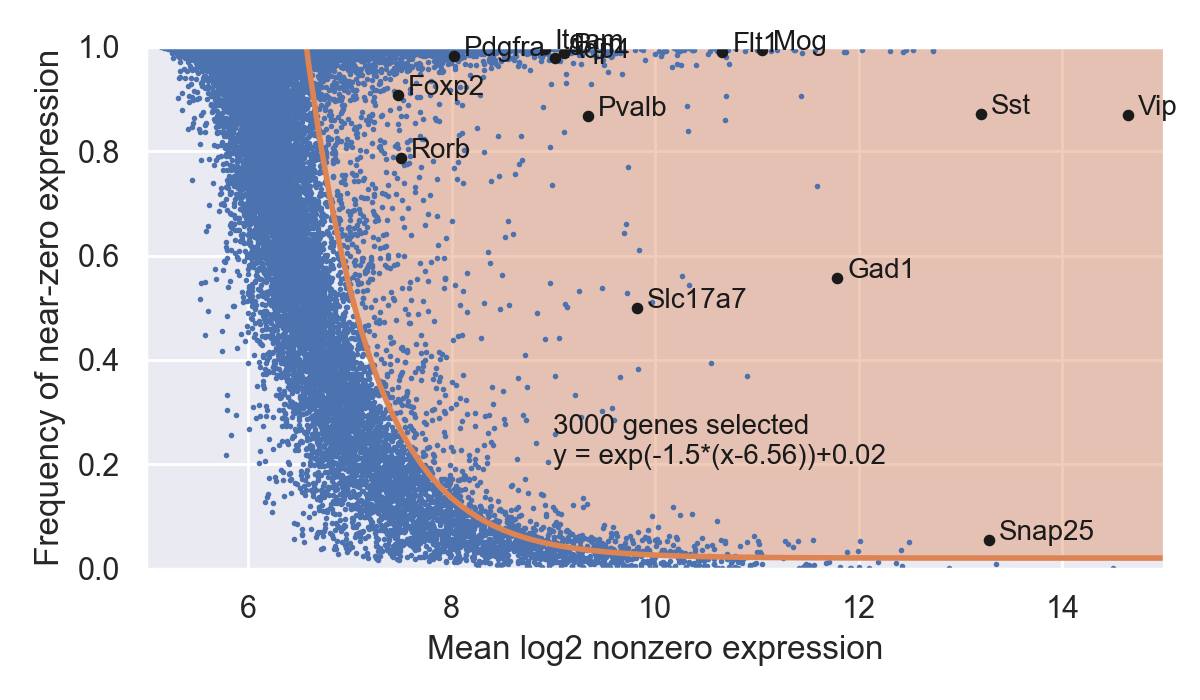

In [8]:
# Feature selection

markerGenes = ['Snap25','Gad1','Slc17a7','Pvalb', 'Sst', 'Vip', 'Aqp4', 
           'Mog', 'Itgam', 'Pdgfra', 'Flt1', 'Bgn', 'Rorb', 'Foxp2']

sns.set()
importantGenesTasic2018 = rnaseqTools.geneSelection(
    tasic2018['counts'], n=3000, threshold=32, 
    markers=markerGenes, genes=tasic2018['genes'])
sns_styleset()

In [5]:
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist

def embedding_quality(X, Z, classes, knn=10, knn_classes=10, subsetsize=1000):
    nbrs1 = NearestNeighbors(n_neighbors=knn).fit(X)
    ind1 = nbrs1.kneighbors(return_distance=False)

    nbrs2 = NearestNeighbors(n_neighbors=knn).fit(Z)
    ind2 = nbrs2.kneighbors(return_distance=False)

    intersections = 0.0
    for i in range(X.shape[0]):
        intersections += len(set(ind1[i]) & set(ind2[i]))
    mnn = intersections / X.shape[0] / knn
    
    cl, cl_inv = np.unique(classes, return_inverse=True)
    C = cl.size
    mu1 = np.zeros((C, X.shape[1]))
    mu2 = np.zeros((C, Z.shape[1]))
    for c in range(C):
        mu1[c,:] = np.mean(X[cl_inv==c,:], axis=0)
        mu2[c,:] = np.mean(Z[cl_inv==c,:], axis=0)
        
    nbrs1 = NearestNeighbors(n_neighbors=knn_classes).fit(mu1)
    ind1 = nbrs1.kneighbors(return_distance=False)
    nbrs2 = NearestNeighbors(n_neighbors=knn_classes).fit(mu2)
    ind2 = nbrs2.kneighbors(return_distance=False)
    
    intersections = 0.0
    for i in range(C):
        intersections += len(set(ind1[i]) & set(ind2[i]))
    mnn_global = intersections / C / knn_classes
    
    subset = np.random.choice(X.shape[0], size=subsetsize, replace=False)
    d1 = pdist(X[subset,:])
    d2 = pdist(Z[subset,:])
    rho = scipy.stats.spearmanr(d1[:,None],d2[:,None]).correlation
    
    return (mnn, mnn_global, rho)

## Main figure with the Tasic dataset

In [9]:
%%time

librarySizes = np.sum(tasic2018['counts'], axis=1)
X = np.log2(tasic2018['counts'][:, importantGenesTasic2018] / librarySizes * 1e+6 + 1)
X = np.array(X)
X = X - X.mean(axis=0)
U,s,V = np.linalg.svd(X, full_matrices=False)
U[:,np.sum(V,axis=1)<0] *= -1
X = np.dot(U, np.diag(s))
X = X[:, np.argsort(s)[::-1]][:,:50]

C = tasic2018['clusterNames'].size
clusterMeans = np.zeros((C, X.shape[1]))
for c in range(C):
    clusterMeans[c,:] = np.mean(X[tasic2018['clusters']==c,:], axis=0)
    
pcaInit = X[:,:2] / np.std(X[:,0]) * 0.0001

CPU times: user 1min 49s, sys: 6.6 s, total: 1min 56s
Wall time: 37.2 s


In [10]:
%%time

ZZ = []
Z = X[:,:2]
ZZ.append(Z)
%time Z = fast_tsne(X, perplexity=30, seed=42)
ZZ.append(Z)
%time Z = fast_tsne(X, perplexity=int(X.shape[0]/100), seed=42)
ZZ.append(Z)
%time Z = fast_tsne(X, perplexity=30, initialization=pcaInit)
ZZ.append(Z)
%time Z = fast_tsne(X, perplexity_list=[30, int(X.shape[0]/100)], initialization=pcaInit, learning_rate=X.shape[0]/12)
ZZ.append(Z)

from sklearn.manifold import MDS
mds = MDS(2, max_iter=100, n_init=1000, random_state=42)
Zmds = mds.fit_transform(clusterMeans)

=============== t-SNE v1.2.1 ===============
fast_tsne data_path: data_2022-05-12 23:13:16.590638-833574241.dat
fast_tsne result_path: result_2022-05-12 23:13:16.590638-833574241.dat
fast_tsne nthreads: 8
Read the following parameters:
	 n 23822 by d 50 dataset, theta 0.500000,
	 perplexity 30.000000, no_dims 2, max_iter 750,
	 stop_lying_iter 250, mom_switch_iter 250,
	 momentum 0.500000, final_momentum 0.800000,
	 learning_rate 1985.166667, max_step_norm 5.000000,
	 K -1, sigma -1.000000, nbody_algo 2,
	 knn_algo 1, early_exag_coeff 12.000000,
	 no_momentum_during_exag 0, n_trees 50, search_k 4500,
	 start_late_exag_iter -1, late_exag_coeff -1.000000
	 nterms 3, interval_per_integer 1.000000, min_num_intervals 50, t-dist df 1.000000
Read the 23822 x 50 data matrix successfully. X[0,0] = 31.364648
Read the initialization successfully.
Will use momentum during exaggeration phase
Computing input similarities...
Using perplexity, so normalizing input data (to prevent numerical problems)


Read the following parameters:
	 n 23822 by d 50 dataset, theta 0.500000,
	 perplexity 0.000000, no_dims 2, max_iter 750,
	 stop_lying_iter 250, mom_switch_iter 250,
	 momentum 0.500000, final_momentum 0.800000,
	 learning_rate 1985.166667, max_step_norm 5.000000,
	 K -1, sigma -1.000000, nbody_algo 2,
	 knn_algo 1, early_exag_coeff 12.000000,
	 no_momentum_during_exag 0, n_trees 50, search_k 35700,
	 start_late_exag_iter -1, late_exag_coeff -1.000000
	 nterms 3, interval_per_integer 1.000000, min_num_intervals 50, t-dist df 1.000000
Read the 23822 x 50 data matrix successfully. X[0,0] = 31.364648
Read the list of perplexities: 30.000000 238.000000 
Read the initialization successfully.
Will use momentum during exaggeration phase
Computing input similarities...
Using perplexity, so normalizing input data (to prevent numerical problems)
Using perplexity, not the manually set kernel width.  K (number of nearest neighbors) and sigma (bandwidth) parameters are going to be ignored.
Using AN

In [117]:
ZZ[-1].shape

(23822, 2)

In [118]:
%%time

quality = []
for Z in ZZ:
    a,b,c = embedding_quality(X, Z, tasic2018['clusters'])
    quality.append((a,b,c))

CPU times: user 1min 11s, sys: 28.8 s, total: 1min 40s
Wall time: 1min 4s


In [119]:
quality

[(0.02046847451935186, 0.4714285714285714, 0.9128306122754034),
 (0.4435899588615565, 0.6360902255639098, 0.5244414130051902),
 (0.2913525312736126, 0.7338345864661654, 0.4514179164554742),
 (0.4444085299303165, 0.6300751879699249, 0.548196402290809),
 (0.3990051213164302, 0.6947368421052632, 0.5488283656159793)]

In [120]:
from umap import UMAP

In [122]:
%%time
Z_tasic_umap = UMAP(random_state=1).fit_transform(X)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


CPU times: user 1min 5s, sys: 3.46 s, total: 1min 8s
Wall time: 51.1 s


In [123]:
embedding_quality(X, Z_tasic_umap, tasic2018['clusters'])

(0.24709512215599028, 0.6248120300751879, 0.5940591687855732)

<IPython.core.display.Javascript object>


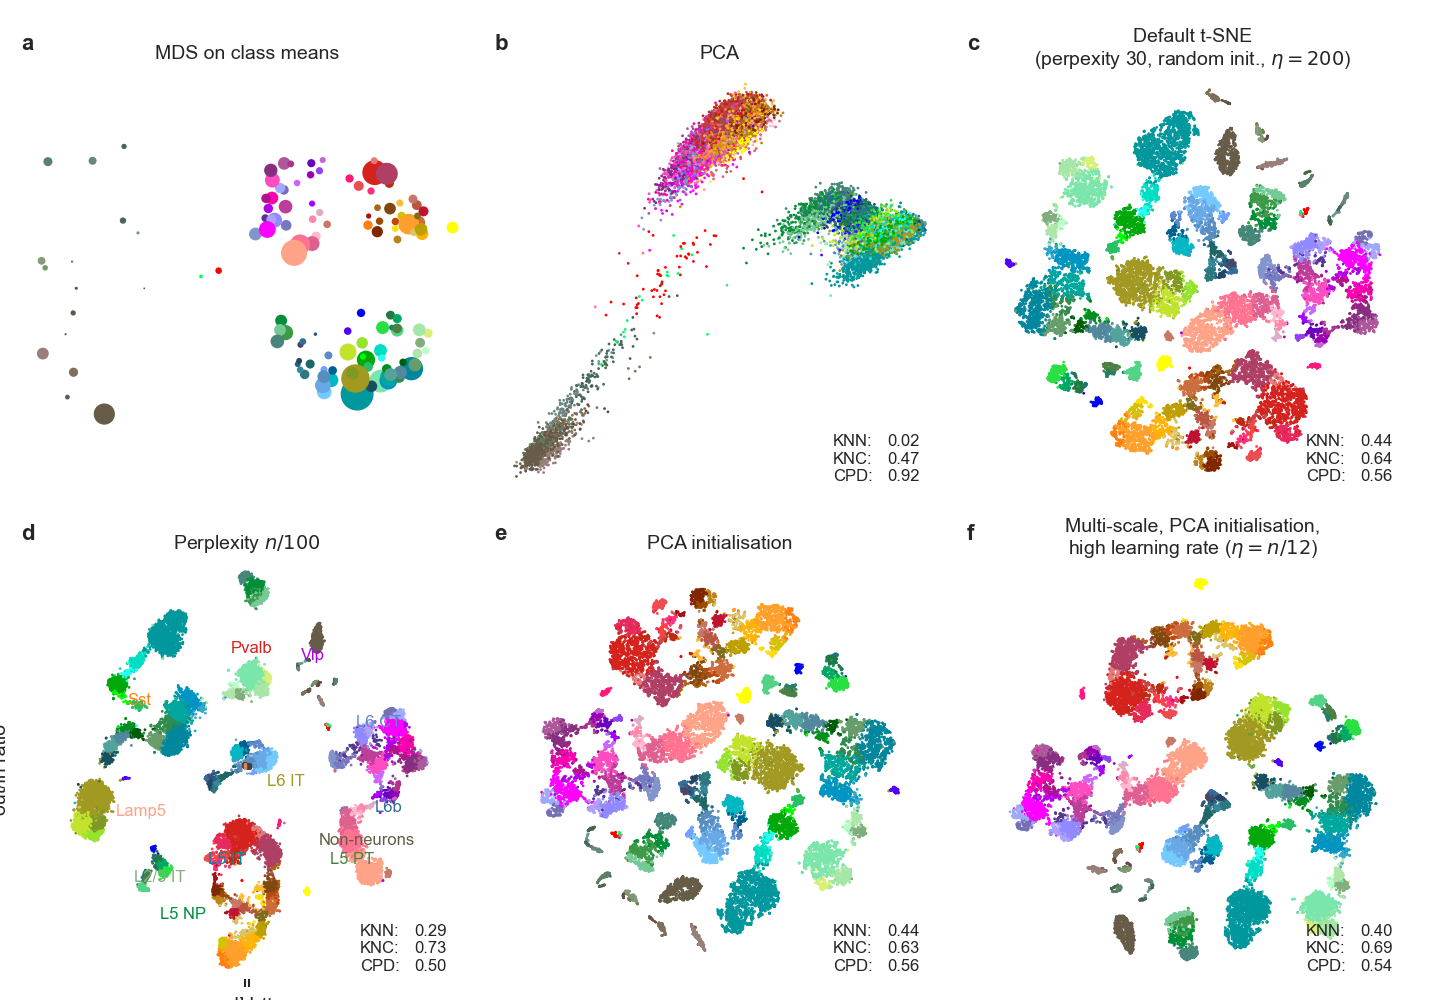

In [12]:
titles = ['MDS on class means', 'PCA', 'Default t-SNE\n(perpexity 30, random init., $\eta=200$)', 'Perplexity $n/100$', 
          'PCA initialisation', 'Multi-scale, PCA initialisation,\nhigh learning rate ($\eta=n/12$)']
letters = 'abcdef'

sns_styleset()
plt.figure(figsize=(7.2, 5))
plt.subplot(231)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.scatter(Zmds[:,0], Zmds[:,1], c=tasic2018['clusterColors'], edgecolor='none',
            s = np.unique(tasic2018['clusters'], return_counts=True)[1]/10)
plt.title(titles[0], va='center')
plt.xticks([])
plt.yticks([])
plt.text(0, 1.05, letters[0], transform = plt.gca().transAxes, fontsize=8, fontweight='bold')

for i,Z in enumerate(ZZ):
    plt.subplot(2,3,2+i)
    plt.gca().set_aspect('equal', adjustable='datalim')
    plt.scatter(Z[:,0], Z[:,1], s=1, c=tasic2018['clusterColors'][tasic2018['clusters']], edgecolor='none',
                rasterized=True)
    plt.title(titles[i+1], va='center')
    plt.text(0.75,.02,'KNN:\nKNC:\nCPD:', transform=plt.gca().transAxes, fontsize=6)
    plt.text(0.87,.02,'{:.2f}\n{:.2f}\n{:.2f}'.format(*quality[i]),
             transform=plt.gca().transAxes, fontsize=6)
    plt.text(0, 1.05, letters[i+1], transform = plt.gca().transAxes, fontsize=8, fontweight='bold')
    plt.xticks([])
    plt.yticks([])
    
sns.despine(left=True, bottom=True)
plt.tight_layout()

classes = {'Lamp5': [-35, -12, 'Lamp5 Lsp1'],
           'Vip':   [15, 30, 'Vip Rspo4 Rxfp1 Chat'],
           'Pvalb': [-4, 32, 'Pvalb Reln Tac1'],
           'Sst':   [-32, 18, 'Sst Myh8 Fibin'],
           'L2/3 IT': [-30, -30, 'L2/3 IT ALM Sla'],
           'L5 IT': [-10, -25, 'L5 IT ALM Tnc'],
           'L6 IT': [6, -4, 'L6 IT VISp Penk Col27a1'],
           'L5 PT': [23,-25, 'L5 PT ALM Hpgd'],
           'L5 NP': [-23, -40, 'L5 NP VISp Trhr Cpne7'],
           'L6 CT': [30,12, 'L6 CT VISp Nxph2 Wls'],
           'L6b':   [35,-11, 'L6b P2ry12'],
           'Non-neurons': [20,-20, 'Astro Aqp4']}
plt.sca(plt.gcf().get_axes()[3])
for c in classes:
    plt.text(classes[c][0], classes[c][1], c, fontsize=6,
         color=tasic2018['clusterColors'][tasic2018['clusterNames']==classes[c][2]][0])

plt.savefig('figures/tasic-variants.png', dpi=150)
plt.savefig('figures/tasic-variants.pdf', dpi=300)
plt.savefig('figures/tasic-variants-600.pdf', dpi=600)

In [13]:
# High learning rate on its own

Z = fast_tsne(X, perplexity=30, seed=42, learning_rate=X.shape[0]/12)
a,b,c = embedding_quality(X, Z, tasic2018['clusters'], knn=10, knn_classes=10, subsetsize=1000)
print('KNN: {:.2f}\nKNC: {:.2f}\nCPD: {:.2f}'.format(a,b,c))

=============== t-SNE v1.2.1 ===============
fast_tsne data_path: data_2022-05-04 13:26:14.631799-297493546.dat
fast_tsne result_path: result_2022-05-04 13:26:14.631799-297493546.dat
fast_tsne nthreads: 8
Read the following parameters:
	 n 23822 by d 50 dataset, theta 0.500000,
	 perplexity 30.000000, no_dims 2, max_iter 750,
	 stop_lying_iter 250, mom_switch_iter 250,
	 momentum 0.500000, final_momentum 0.800000,
	 learning_rate 1985.166667, max_step_norm 5.000000,
	 K -1, sigma -1.000000, nbody_algo 2,
	 knn_algo 1, early_exag_coeff 12.000000,
	 no_momentum_during_exag 0, n_trees 50, search_k 4500,
	 start_late_exag_iter -1, late_exag_coeff -1.000000
	 nterms 3, interval_per_integer 1.000000, min_num_intervals 50, t-dist df 1.000000
Read the 23822 x 50 data matrix successfully. X[0,0] = 31.364648
Read the initialization successfully.
Will use momentum during exaggeration phase
Computing input similarities...
Using perplexity, so normalizing input data (to prevent numerical problems)
